<a href="https://colab.research.google.com/github/liutianlin0121/seisLM/blob/main/examples/demo_seislm_foreshock_aftershock_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q seisbench lightning ml-collections einops gdown wandb gitpython torchtune torchao

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.6/596.6 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

*This cell is required to circumvent an issue with colab and obspy. For details, check this issue in the obspy documentation: https://github.com/obspy/obspy/issues/2547*

In [ ]:
try:
    import obspy
    obspy.read()
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()

In [ ]:
import gdown
!git clone https://github.com/liutianlin0121/seisLM.git
%cd /content/seisLM

# Once cloned the repository, navigate to the root and install it with `pip install -e .`
!pip install -e .
import seisLM

Cloning into 'seisLM'...
remote: Enumerating objects: 2161, done.
remote: Counting objects: 100% (251/251), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 2161 (delta 130), reused 165 (delta 69), pack-reused 1910 (from 1)
Receiving objects: 100% (2161/2161), 22.02 MiB | 36.78 MiB/s, done.
Resolving deltas: 100% (1463/1463), done.
/content/seisLM
Obtaining file:///content/seisLM
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for seisLM (pyproject.toml) ... done
  Created wheel for seisLM: filename=seisLM-0.1-0.editable-py3-none-any.whl size=3194 sha256=885dd13bc64859de9938623c78be55c1afd8abc634590ce9dcf225cdda6f5420
  Stored in directory: /tmp/pip-ephem-wheel-cache-swhm7llg/wheels/d8/36/c8/79fbc9cd21ff060cc85b0eed684f97009d6bd65b0d8bba9b79
Successfully built seisLM


## Download the foreshock--aftershock dataset



In [ ]:
# Download the foreshock--aftershock dataset
foreshock_aftershock_file_id = '1saaRH175pSFgl0zfQWFpedgj44pJKK3_'
foreshock_aftershock_destination = '/content/seisLM/data/foreshock_aftershock_NRCA/'
gdown.download(
    f'https://drive.google.com/uc?id={foreshock_aftershock_file_id}',
    foreshock_aftershock_destination,
    quiet=True
)

!unzip {foreshock_aftershock_destination}wetransfer_classify_generic_norcia-py_2024-06-24_1530.zip -d {foreshock_aftershock_destination}


Archive:  /content/seisLM/data/foreshock_aftershock_NRCA/wetransfer_classify_generic_norcia-py_2024-06-24_1530.zip
Written using Zippy
 extracting: /content/seisLM/data/foreshock_aftershock_NRCA/Classify_generic_Norcia.py  
 extracting: /content/seisLM/data/foreshock_aftershock_NRCA/dataframe_post_NRCA.csv  
 extracting: /content/seisLM/data/foreshock_aftershock_NRCA/dataframe_pre_NRCA.csv  
 extracting: /content/seisLM/data/foreshock_aftershock_NRCA/dataframe_visso_NRCA.csv  
 extracting: /content/seisLM/data/foreshock_aftershock_NRCA/utils_pre_post.py  


## Download the pretrained **SeisLM base** model


In [ ]:
seisLM_base_ckpt_file_id = '12L2Js1DIXCIxacQJ4K0hRKJ6qHFrQ7K-'
seisLM_base_ckpt_destination = '/content/seisLM/results/models/pretrained_seislm_base/checkpoints/'
gdown.download(
    f'https://drive.google.com/uc?id={seisLM_base_ckpt_file_id}',
    seisLM_base_ckpt_destination,
    quiet=True
)


'/content/seisLM/results/models/pretrained_seislm_base/checkpoints/epoch=39-step=1203000.ckpt'

# Import packages

In [ ]:
import torch
import ml_collections
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
import time
from ml_collections import ConfigDict
import lightning as L
import torch
from lightning.pytorch import seed_everything
from lightning.pytorch.callbacks import (LearningRateMonitor, ModelCheckpoint)
from lightning.pytorch.loggers import WandbLogger
import ml_collections
import os
import json
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from seisLM.data_pipeline import \
    foreshock_aftershock_dataloaders as dataloaders
from seisLM.model.task_specific import foreshock_aftershock_models
from seisLM.utils import project_path
from seisLM.utils.wandb_utils import shutdown_cleanup_thread
from seisLM.model.task_specific import shared_task_specific
import seisLM.model.foundation.multidim_wav2vec2

def check_gpu():
    if torch.cuda.is_available():
        print("✅ GPU is enabled for PyTorch.")
        print(f"🚀 GPU Device Name: {torch.cuda.get_device_name(0)}")
    else:
        print("❌ GPU is **not** enabled for PyTorch.")
        print("⚠️ To use a GPU, go to 'Runtime' > 'Change runtime type' and select 'GPU' as the hardware accelerator.")

check_gpu()

✅ GPU is enabled for PyTorch.
🚀 GPU Device Name: NVIDIA A100-SXM4-40GB


In [ ]:
# The ratio 0.7 here is the base fraction of training dataset
# (out of the whole dataset that contains training, validation,
# and testing sets).
BASE_TRAINING_FRACTION = 0.7

def train_foreshock_aftershock(
  config: ml_collections.ConfigDict,
  task_name: str,
  save_checkpoint: bool = False,
  run_name_prefix: str = "",
  ) -> None:
  """Runs the model training defined by the config.
  """
  seed = config.get("seed", 42)
  seed_everything(seed)


  loaders = dataloaders.prepare_foreshock_aftershock_dataloaders(
      num_classes=config.model_args.num_classes,
      **config.data_args,
  )

  max_train_steps = config.trainer_args.max_epochs * len(
    loaders['train'])

  config.trainer_args.max_train_steps = max_train_steps


  if config.model_name == 'Wav2Vec2ForSequenceClassification':
    LitModel = foreshock_aftershock_models.Wav2vec2ShockClassifierLit
  elif config.model_name == 'Conv1DShockClassifier':
    LitModel = foreshock_aftershock_models.Conv1DShockClassifierLit
  else:
    raise ValueError(f"Model {config.model_name} not supported")

  model = LitModel(
      model_config=config.model_args,
      training_config=config.trainer_args,
  )

  formatted_time = time.strftime(
    "%Y-%m-%d-%Hh-%Mm-%Ss", time.localtime(time.time())
  )

  relative_fraction = round(
    config.data_args.train_frac / BASE_TRAINING_FRACTION, 3
  )

  run_name = f"nc_{config.model_args.num_classes}"\
    + f"_frac_{relative_fraction}"\
    + f"_{formatted_time}"

  logger = WandbLogger(
      # Groups related experiments together
      project=task_name,
      # Describes a specific experiment within the project
      name=f"{run_name_prefix}_{run_name}",
      # Filter runs based on keywords or categories.
      tags=[
            f"num_classes_{config.model_args.num_classes}_train_frac_{relative_fraction}",
            f"model_{config.model_name}",
      ],
      # A unique identifier for the run
      id=f"{run_name_prefix}_{run_name}",
      save_code=True,
      offline=config.get("wandb_offline", True),
      save_dir=project_path.MODEL_SAVE_DIR,
      config=config,
  )

  slurm_job_id = os.getenv('SLURM_JOB_ID')
  if slurm_job_id:
    logger.log_hyperparams({"slurm_job_id": slurm_job_id})

  logger.log_hyperparams(config.to_dict())
  logger.log_hyperparams(model.model_config.to_dict())

  lr_monitor = LearningRateMonitor(logging_interval='step')
  callbacks = [lr_monitor]

  if save_checkpoint:
    checkpoint_callback = ModelCheckpoint(
        monitor="val/loss",
        save_top_k=1,
        save_last=True,
        mode='min',
        filename="{epoch}-{step}",
    )
    callbacks.append(checkpoint_callback)
    enable_checkpointing = True
  else:
    enable_checkpointing = False
    print('Checkpoints will not be saved.')


  if (config.model_name == "Wav2Vec2ForSequenceClassification" and
    config.trainer_args.unfreeze_base_at_epoch > 0):
    callbacks.append(
      shared_task_specific.BaseModelUnfreeze(
        unfreeze_at_epoch=config.trainer_args.unfreeze_base_at_epoch
      )
    )

  log_every_n_steps = min(
    50, len(loaders['train']) // config.trainer_args.devices
  )

  # Training loop
  trainer = L.Trainer(
      profiler="simple",
      default_root_dir=project_path.MODEL_SAVE_DIR,
      logger=logger,
      callbacks=callbacks,
      log_every_n_steps=log_every_n_steps,
      devices=config.trainer_args.devices,
      strategy=config.trainer_args.strategy,
      accelerator=config.trainer_args.accelerator,
      max_epochs=config.trainer_args.max_epochs,
      enable_checkpointing=enable_checkpointing,
  )

  trainer.fit(model, loaders['train'], loaders['test'])
  trainer.test(ckpt_path="last", dataloaders=loaders['test'])

  return logger.experiment.id

In [ ]:

config_path = "/content/seisLM/seisLM/configs/foreshock_aftershock/seisLM_base_shock_classifier.json"
with open(config_path, "r", encoding="utf-8") as f:
  config = json.load(f)
  config = ml_collections.ConfigDict(config)

config.model_args.pretrained_ckpt_path ='/content/seisLM/results/models/pretrained_seislm_base/checkpoints/epoch=39-step=1203000.ckpt'
config.trainer_args.devices = 1
config.trainer_args.strategy = 'auto'
# config.trainer_args.max_epochs = 1 # FIXME

config.data_args.batch_size = 32
config.data_args.num_workers = 2
config.model_args.num_classes = 9


In [ ]:
run_name_prefix = config_path.split("/")[-1].split(".")[0]

ckpt_folder_name = train_foreshock_aftershock(
    config,
    task_name='foreshock_aftershock',
    save_checkpoint=True,
    run_name_prefix=run_name_prefix,
)


INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/seisLM/res

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=15` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
INFO: FIT Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                               	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                     

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.7080979347229004     │
│         test/loss         │    1.1307100057601929     │
└───────────────────────────┴───────────────────────────┘

INFO: TEST Profiler Report

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                               	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                                	|  -

In [ ]:
def get_confusion_matrix(model_ckpt_path, num_classes, data_args):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  loaders = dataloaders.prepare_foreshock_aftershock_dataloaders(
    num_classes=num_classes, **data_args
  )

  model = foreshock_aftershock_models.Wav2vec2ShockClassifierLit.load_from_checkpoint(
    model_ckpt_path, load_pretrained=False
  )

  model = model.to(device)
  model = model.eval()

  all_gt_class = []
  all_pred_class = []
  all_losses = []

  model = model.to(device)
  model.eval()

  for X, y in loaders["test"]:
    with torch.no_grad():
      logits = model(X.to(device)).cpu()
      pred_class = np.argmax(logits.numpy(), axis=1)
      loss = torch.nn.functional.cross_entropy(logits, y)
      all_losses.append(loss.item())

    all_gt_class.append(y)
    all_pred_class.append(pred_class)

  all_gt_class = np.concatenate(all_gt_class)
  all_pred_class = np.concatenate(all_pred_class)

  cm = confusion_matrix(all_gt_class, all_pred_class)
  cm_percentage = 100 * cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  return np.rint(cm_percentage)

In [ ]:
confusion_mat = get_confusion_matrix(
    f"/content/seisLM/results/models/foreshock_aftershock/{ckpt_folder_name}/checkpoints/last.ckpt",
    num_classes=config.model_args.num_classes,
    data_args=config.data_args
)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [ ]:
display_labels_dict = {
  2: ["Foreshock", "Aftershock"],
  4: ["FEQ1", "FEQ2", "AEQ1", "AEQ2"],
  8: ["FEQ1", "FEQ2", "FEQ3", "FEQ4", "AEQ1", "AEQ2", "AEQ3", "AEQ4"],
  9: [
    "FEQ1",
    "FEQ2",
    "FEQ3",
    "FEQ4",
    "Visso",
    "AEQ1",
    "AEQ2",
    "AEQ3",
    "AEQ4",
  ],
}

Text(0.5, 1.0, 'Confusion Matrix; Acc: 70.78%')

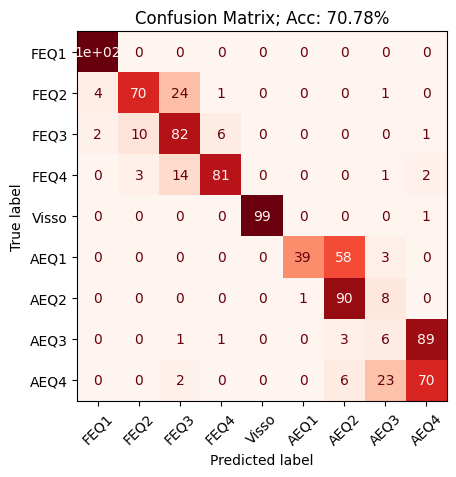

In [ ]:
disp = ConfusionMatrixDisplay(
      confusion_matrix=confusion_mat,
      display_labels=display_labels_dict[config.model_args.num_classes],
)
disp.plot(xticks_rotation=45, colorbar=False, cmap="Reds")
plt.title(f"Confusion Matrix; Acc: {confusion_mat.diagonal().mean():.2f}%")